In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from astropy.io import fits
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import light_curve as lc
plt.style.use('seaborn-whitegrid')

In [3]:
# main dataframe with all info
df = pd.read_csv('data/gbmdatacleaned.csv', index_col=0)

In [4]:
# dataframe with reference and target GRB info
newdf = pd.read_csv('data/distance_dat_file.csv')

In [5]:
def get_subset_df(fulldf, sub_df):
    ref_rows = []
    ref_idx = []
    for i in range(sub_df.shape[0]):
        x = sub_df.iloc[i].name
        df1 = fulldf[:x]
        ref_row = df1[df1['Is Reference'] == 1].iloc[-1]
        if ref_row.Index not in ref_idx:
            ref_rows.append(ref_row)
            ref_idx.append(ref_row.Index)
    df2 = pd.DataFrame(ref_rows)
    return pd.concat([sub_df, df2], sort=False).sort_index()

In [6]:
def get_dict_from_df(df):
    dct = dict()
    isref = df['Is Reference'].values
    idx = df['Index'].values
    for i, (x,y) in enumerate(zip(isref, idx)):
        if x:
            i += 1
            ls = []
            while i < len(isref) and isref[i] == 0:
                ls.append(idx[i])
                i += 1
            dct[y] = ls
    
    return dct

In [7]:
def get_fit_file(name):
    d = newdf.loc[newdf['Name'] == name]['Brightest Detector'].values[0]
    # try suffix _v01 or _v00
    dig = 0
    path = ''
    while not os.path.exists(path):
        path = 'C:/Users/hhsud/Downloads/GRBS/glg_tte_' + d + '_bn' + name[3:] + '_v0' + str(dig) + '.fit'
        dig += 1
        if dig > 100:
            print(path)
            raise FileNotFoundError

    return fits.open(path)

In [8]:
result_subdf = newdf.loc[newdf.Sigma < 1, :]
resultdf = get_subset_df(newdf, result_subdf)
resultdf.shape

(18, 10)

In [9]:
resultdf

,Index,Is Reference,Name,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma
214,49,1,GRB120114433,n0,263.23,-75.64,2.752,1.0,0.0,NaN
215,56,0,GRB110911071,n2,258.58,-66.98,8.960,1.0,570.0,0.094
266,57,1,GRB200908886,n0,169.53,-66.97,6.144,1.0,0.0,NaN
275,271,0,GRB081006872,n6,172.20,-61.00,3.328,1.0,656.0,0.496
397,75,1,GRB211219910,n2,68.54,-63.18,73.729,1.0,0.0,NaN
413,309,0,GRB180412425,n6,62.32,-59.01,20.992,1.0,2281.0,0.029
449,80,1,GRB200117517,na,129.67,-62.51,28.416,1.0,0.0,NaN
453,171,0,GRB111107035,n8,129.48,-66.52,12.032,1.0,1263.0,0.600
600,103,1,GRB190906767,n4,171.84,-71.57,23.040,1.0,0.0,NaN
601,157,0,GRB150404733,n8,165.91,-67.37,4.864,1.0,1068.0,0.329


### Donut Plot

In [10]:
pairs_value = [9, 1260]
label_value = ['Less than 1 sigma', 'Pairs Analyzed']

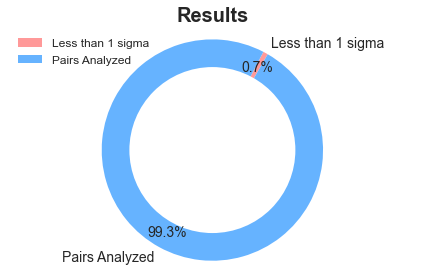

In [11]:
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.05,0.05)

fig1, ax1 = plt.subplots()
ax1.pie(pairs_value, colors = colors, labels=label_value, autopct='%.1f%%', 
        pctdistance=0.85, startangle=60, textprops={'fontsize':14})
#draw circle
centre_circle = plt.Circle((0,0),0.75,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
ax1.set_title('Results', fontsize=20, fontweight='bold')
ax1.legend(loc='upper left', fontsize=12) 
plt.tight_layout()
plt.show()

In [12]:
dct = get_dict_from_df(resultdf)

In [13]:
delays = []
for i, (key, value) in enumerate(dct.items()):
    ref_time = datetime.strptime(df.trigger_time.iloc[key], '%Y-%m-%d %H:%M:%S.%f')
    delays.append(None)
    for x in value:
        tar_time = datetime.strptime(df.trigger_time.iloc[x], '%Y-%m-%d %H:%M:%S.%f')
        delay = abs(ref_time - tar_time)
        delays.append(delay)

In [14]:
resultdf['Delay'] = delays

In [15]:
resultdf

,Index,Is Reference,Name,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma,Delay
214,49,1,GRB120114433,n0,263.23,-75.64,2.752,1.0,0.0,NaN,NaT
215,56,0,GRB110911071,n2,258.58,-66.98,8.960,1.0,570.0,0.094,125 days 08:41:57.646000
266,57,1,GRB200908886,n0,169.53,-66.97,6.144,1.0,0.0,NaN,NaT
275,271,0,GRB081006872,n6,172.20,-61.00,3.328,1.0,656.0,0.496,4355 days 00:20:05.836000
397,75,1,GRB211219910,n2,68.54,-63.18,73.729,1.0,0.0,NaN,NaT
413,309,0,GRB180412425,n6,62.32,-59.01,20.992,1.0,2281.0,0.029,1347 days 11:37:40
449,80,1,GRB200117517,na,129.67,-62.51,28.416,1.0,0.0,NaN,NaT
453,171,0,GRB111107035,n8,129.48,-66.52,12.032,1.0,1263.0,0.600,2993 days 11:33:41.048000
600,103,1,GRB190906767,n4,171.84,-71.57,23.040,1.0,0.0,NaN,NaT
601,157,0,GRB150404733,n8,165.91,-67.37,4.864,1.0,1068.0,0.329,1616 days 00:50:05.569000


In [16]:
def roundl(x):
    return [round(y,3) for y in x]

In [17]:
delaysns =  resultdf.Delay[resultdf.Delay.notna()].values
delayss = delaysns/np.timedelta64(1, 's')
delaydays = delaysns / np.timedelta64(1, 'D')
roundl(delaydays)

[125.362,
 4355.014,
 1347.484,
 2993.482,
 1616.035,
 81.06,
 2427.3,
 4641.75,
 3631.097]

In [18]:
SPEED_OF_LIGHT = 3*(10**8)
GRAVITATIONAL_CONSTANT = 6.673*(10**-11)
def mass_of_lens(t):
    return t * SPEED_OF_LIGHT**3 / GRAVITATIONAL_CONSTANT

In [19]:
masses = list(map(mass_of_lens, delayss))
SOLAR_MASS = 1.989 * 10**30
masses = [np.format_float_scientific(x/SOLAR_MASS, precision=3) for x in masses]
masses

['2.203e+12',
 '7.654e+13',
 '2.368e+13',
 '5.261e+13',
 '2.840e+13',
 '1.425e+12',
 '4.266e+13',
 '8.158e+13',
 '6.382e+13']

In [20]:
latex_table = pd.DataFrame({'Reference GRB':resultdf[resultdf['Is Reference']==1].Name.values,
                            'Target GRB':resultdf[resultdf['Is Reference']==0].Name.values,
                            'Sigma':resultdf[resultdf['Is Reference']==0].Sigma.values,
                            'Delay (days)':roundl(delaydays),
                            'Mass of Lens':masses})

In [21]:
print(latex_table.drop(['Mass of Lens'], axis=1).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
Reference GRB &   Target GRB &  Sigma &  Delay (days) \\
\midrule
 GRB120114433 & GRB110911071 &  0.094 &       125.362 \\
 GRB200908886 & GRB081006872 &  0.496 &      4355.014 \\
 GRB211219910 & GRB180412425 &  0.029 &      1347.484 \\
 GRB200117517 & GRB111107035 &  0.600 &      2993.482 \\
 GRB190906767 & GRB150404733 &  0.329 &      1616.035 \\
 GRB080717543 & GRB081006604 &  0.938 &        81.060 \\
 GRB180630335 & GRB111107035 &  0.125 &      2427.300 \\
 GRB220124074 & GRB090510325 &  0.029 &      4641.750 \\
 GRB090924625 & GRB190903722 &  0.740 &      3631.097 \\
\bottomrule
\end{tabular}



C:\Users\hhsud\AppData\Local\Temp\ipykernel_22992\1340701494.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_table.drop(['Mass of Lens'], axis=1).to_latex(index=False))


In [22]:
print(latex_table.drop(['Sigma'], axis=1).to_latex(index=False))

\begin{tabular}{llrl}
\toprule
Reference GRB &   Target GRB &  Delay (days) & Mass of Lens \\
\midrule
 GRB120114433 & GRB110911071 &       125.362 &    2.203e+12 \\
 GRB200908886 & GRB081006872 &      4355.014 &    7.654e+13 \\
 GRB211219910 & GRB180412425 &      1347.484 &    2.368e+13 \\
 GRB200117517 & GRB111107035 &      2993.482 &    5.261e+13 \\
 GRB190906767 & GRB150404733 &      1616.035 &    2.840e+13 \\
 GRB080717543 & GRB081006604 &        81.060 &    1.425e+12 \\
 GRB180630335 & GRB111107035 &      2427.300 &    4.266e+13 \\
 GRB220124074 & GRB090510325 &      4641.750 &    8.158e+13 \\
 GRB090924625 & GRB190903722 &      3631.097 &    6.382e+13 \\
\bottomrule
\end{tabular}



C:\Users\hhsud\AppData\Local\Temp\ipykernel_22992\3852401599.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(latex_table.drop(['Sigma'], axis=1).to_latex(index=False))


In [23]:
resultdf

,Index,Is Reference,Name,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma,Delay
214,49,1,GRB120114433,n0,263.23,-75.64,2.752,1.0,0.0,NaN,NaT
215,56,0,GRB110911071,n2,258.58,-66.98,8.960,1.0,570.0,0.094,125 days 08:41:57.646000
266,57,1,GRB200908886,n0,169.53,-66.97,6.144,1.0,0.0,NaN,NaT
275,271,0,GRB081006872,n6,172.20,-61.00,3.328,1.0,656.0,0.496,4355 days 00:20:05.836000
397,75,1,GRB211219910,n2,68.54,-63.18,73.729,1.0,0.0,NaN,NaT
413,309,0,GRB180412425,n6,62.32,-59.01,20.992,1.0,2281.0,0.029,1347 days 11:37:40
449,80,1,GRB200117517,na,129.67,-62.51,28.416,1.0,0.0,NaN,NaT
453,171,0,GRB111107035,n8,129.48,-66.52,12.032,1.0,1263.0,0.600,2993 days 11:33:41.048000
600,103,1,GRB190906767,n4,171.84,-71.57,23.040,1.0,0.0,NaN,NaT
601,157,0,GRB150404733,n8,165.91,-67.37,4.864,1.0,1068.0,0.329,1616 days 00:50:05.569000


### Plots of light curve
Legend : <br>
Blue = Reference <br>
Green = Target

In [24]:
def make_hist(ref, ref_name, tar, tar_name, info_tuple):
    df_ref = lc.df_from_fit_file(ref)
    df_tar = lc.df_from_fit_file(tar)
    t90_ref = lc.get_t90(ref_name)
    t90_tar = lc.get_t90(tar_name)
    t90_start_ref = float(df[df['name'] == ref_name].t90_start.values)
    t90_start_tar = float(df[df['name'] == tar_name].t90_start.values)
    start1 = -10
    end1 = max(t90_ref, t90_tar) + 50
    size1 = 0.1 if t90_ref < 2 else 1
    size2 = 0.1 if t90_tar < 2 else 1
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f'Distance : {info_tuple[0]}, Sigma : {info_tuple[1]}, Delay : {info_tuple[2]}', fontsize=16)
    ref = axs[0].hist(df_ref.TTIME, bins=int((end1 - start1)/size1), range=(start1,end1),
                label = ref_name, histtype='step', color='b')
    
    tar = axs[1].hist(df_tar.TTIME, bins=int((end1 - start1)/size2), range=(start1,end1),
                label = tar_name, histtype='step', color='g')

    axs[0].axvline(t90_start_ref, color='b', linestyle='--', alpha=0.5, label='T90 start')
    axs[0].axvline(t90_start_ref + t90_ref, color='r', linestyle='--', alpha=0.5, label='T90 stop')
    axs[1].axvline(t90_start_tar, color='b', linestyle='--', alpha=0.5)
    axs[1].axvline(t90_start_tar + t90_tar, color='r', linestyle='--', alpha=0.5)

    axs[0].set_ylim([min(ref[0]) - 50, max(ref[0]) + 50])
    axs[1].set_ylim([min(ref[0]) - 50, max(ref[0]) + 50])

    fig.supxlabel('Time')
    fig.supylabel('Counts per sec')

    ref[2][0].set_xy(ref[2][0].get_xy()[1:])
    tar[2][0].set_xy(tar[2][0].get_xy()[1:])
    ref[2][0].set_xy(ref[2][0].get_xy()[:-1])
    tar[2][0].set_xy(tar[2][0].get_xy()[:-1])
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)
    fig.legend(frameon=True, bbox_to_anchor=(0.9,0.5), ncol=2, borderaxespad=0, loc='center right')
    plt.savefig(f'res{make_hist.counter}.png')
    make_hist.counter += 1

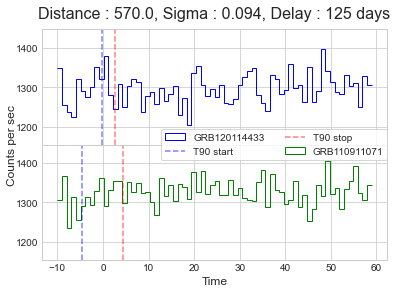

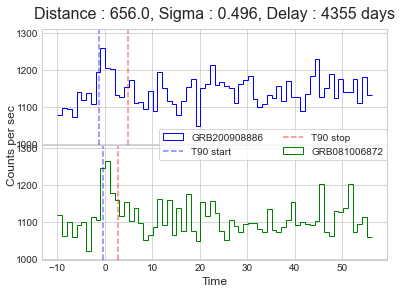

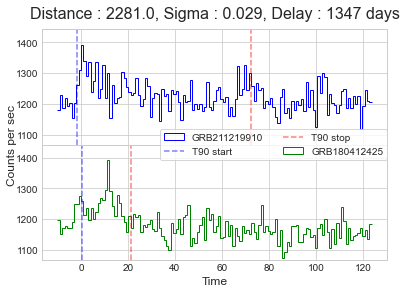

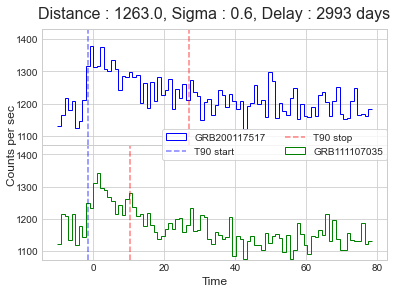

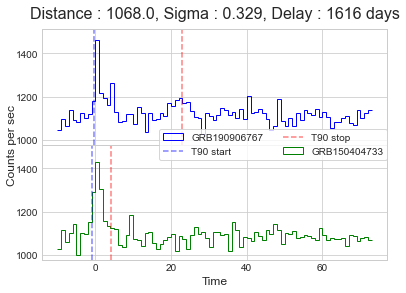

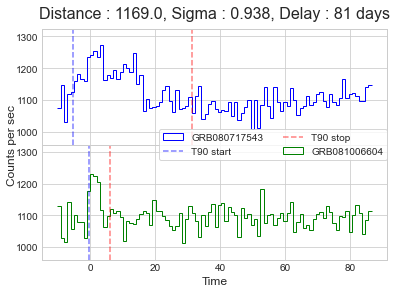

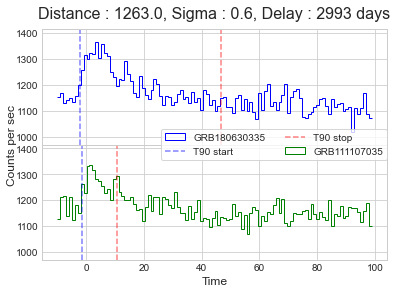

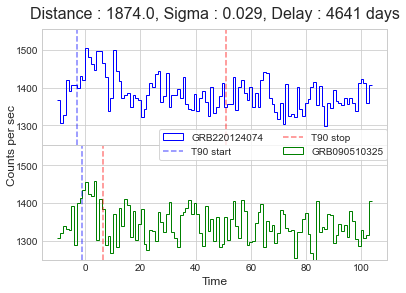

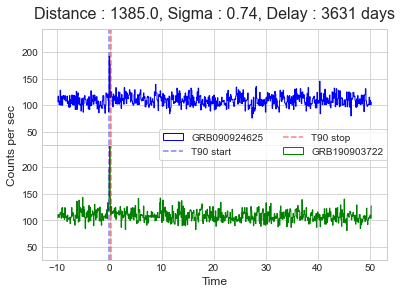

In [25]:
make_hist.counter = 0
for i, (key, value) in enumerate(dct.items()):
    ref_name = resultdf[resultdf.Index == key]['Name'].values[0]
    ref = get_fit_file(ref_name)
    for x in value:
        tar_name = resultdf[resultdf.Index == x]['Name'].values[0]
        tar = get_fit_file(tar_name)
        row = resultdf.loc[resultdf.Index == x]
        info_tuple = (row.Distance.values[0], row.Sigma.values[0], 
                    row.Delay.values[0].astype("timedelta64[D]"))
        make_hist(ref, ref_name, tar, tar_name, info_tuple)

In [26]:
def floatify(arr):
    return [float(x) for x in arr]

### Time delay vs $\sigma$

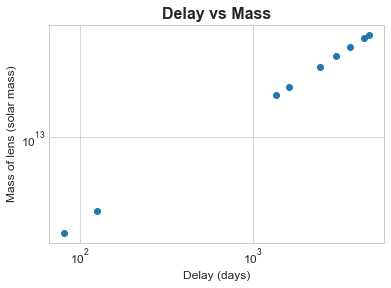

In [30]:
masses = floatify(masses)
plt.scatter(delaydays, masses)
plt.title('Delay vs Mass', fontweight='bold', fontsize=16)
plt.xlabel('Delay (days)', fontsize=12)
plt.ylabel('Mass of lens (solar mass)', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', labelsize=12)

### T90 ref vs T90 target

In [28]:
t90x = []
t90y = []
t90x_err = []
t90y_err = []
for key, value in dct.items():
    a = resultdf.loc[resultdf.Index == key].t90.values[0]
    errx = float(df.iloc[key].t90_error)
    for x in value:
        row = resultdf.loc[resultdf.Index==x]
        b = row.t90.values[0]
        t90x.append(a)
        t90y.append(b)
        t90x_err.append(errx)
        t90y_err.append(float(df.iloc[x].t90_error))

AttributeError: 'Series' object has no attribute 't90_error'

In [ ]:
plotdf_t90 = pd.DataFrame({'x':t90x, 'y':t90y, 'sigma_less_1':sigma_less_1})

In [ ]:
def powerlaw(x, a, b) :
    return a * np.sign(x) * np.power(np.abs(x), b)

In [ ]:
popt, pcov = curve_fit(powerlaw, plotdf_t90.x, plotdf_t90.y)
fittedy = [powerlaw(x, popt[0], popt[1]) for x in plotdf_t90.x]

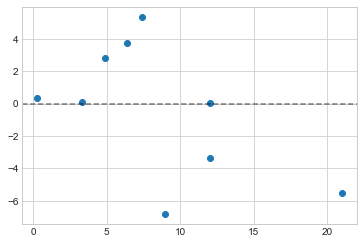

In [ ]:
t90_resid = fittedy - plotdf_t90.y
plt.scatter(plotdf_t90.y, t90_resid)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
one_sigma_band = abs(t90_resid.mean())

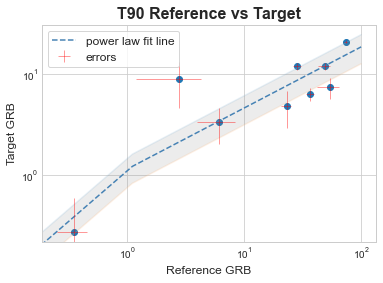

In [ ]:
xlim = np.linspace(-10, 100, 100)

y1 = powerlaw(xlim, popt[0] + one_sigma_band, popt[1])
y = powerlaw(xlim, popt[0], popt[1])
y2 = powerlaw(xlim, popt[0] - one_sigma_band, popt[1])

plt.scatter(plotdf_t90.x, plotdf_t90.y)
plt.plot(xlim, y1, alpha=0.1)
plt.plot(xlim, y, '--', color='steelblue', label='power law fit line')
plt.plot(xlim, y2, alpha=0.1)
plt.fill_between(xlim, y1, y2, facecolor="gray", alpha=0.15)
plt.title('T90 Reference vs Target', fontweight='bold', fontsize=16)
plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='r', linewidth=1, alpha=0.4,
            label='errors')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Target GRB', fontsize=12)
plt.xlabel('Reference GRB', fontsize=12)
plt.legend(frameon=True, fontsize=12)

### Fluence ref vs Fluence target

In [ ]:
fluencex, fluencey = [], []
fx_err, fy_err = [], []
for key, value in dct.items():
    a = df.iloc[key].fluence
    for x in value:
        row = resultdf.loc[resultdf.Index == x]
        b = df.iloc[x].fluence
        fluencex.append(a)
        fluencey.append(b)
        fx_err.append(df.iloc[key].fluence_error)
        fy_err.append(df.iloc[x].fluence_error)

In [ ]:
fluencex = floatify(fluencex)
fluencey = floatify(fluencey)
fx_err = floatify(fx_err)
fy_err = floatify(fy_err)

In [ ]:
plotdf_fluence = pd.DataFrame({'x':fluencex, 'y':fluencey, 'x_err':fx_err, 'y_err':fy_err})

In [ ]:
poptf, pcovf = curve_fit(powerlaw, plotdf_fluence.x, plotdf_fluence.y)
fitted_fy = [powerlaw(x, poptf[0], poptf[1]) for x in plotdf_fluence.x]

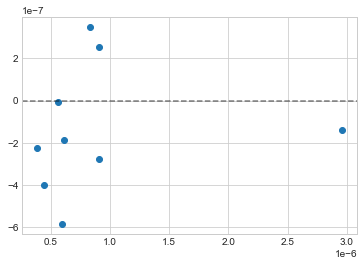

In [ ]:
fluence_resid = fitted_fy - plotdf_fluence.y
plt.scatter(plotdf_fluence.y, fluence_resid)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
one_sigma_band = abs(fluence_resid.mean())

In [ ]:
min(plotdf_fluence.x), max(plotdf_fluence.x)

(1.4875e-07, 7.832e-06)

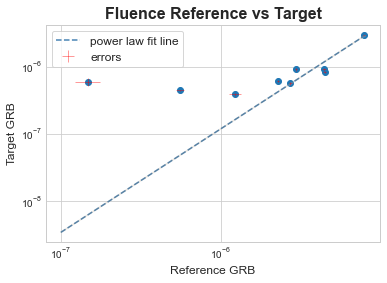

In [ ]:
xlim = np.linspace(1e-07, 8e-06, 100)

y1 = powerlaw(xlim, poptf[0] + one_sigma_band, poptf[1])
y = powerlaw(xlim, poptf[0], poptf[1])
y2 = powerlaw(xlim, poptf[0] - one_sigma_band, poptf[1])

plt.scatter(plotdf_fluence.x, plotdf_fluence.y)
plt.plot(xlim, y1, alpha=0.1)
plt.plot(xlim, y, '--', color='steelblue', label='power law fit line')
plt.plot(xlim, y2, alpha=0.1)
plt.fill_between(xlim, y1, y2, facecolor="grey", alpha=0.15)
plt.title('Fluence Reference vs Target', fontweight='bold', fontsize=16)
plt.errorbar(plotdf_fluence.x, plotdf_fluence.y, xerr=fx_err, yerr=fy_err, fmt='none', ecolor='r', linewidth=1, alpha=0.4,
            label='errors')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Target GRB', fontsize=12)
plt.xlabel('Reference GRB', fontsize=12)
plt.legend(frameon=True, fontsize=12)

### Distribution of delays

In [ ]:
sub_df3 = resultdf.loc[resultdf.Sigma < 0.5, :]
df2 = get_subset_df(newdf, sub_df3) 

In [ ]:
df2['Delay_day'] = df2.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [ ]:
delay_days = [x for x in df2.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 1')

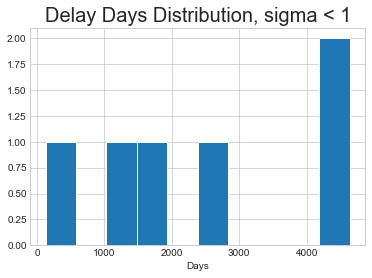

In [ ]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 1', fontsize=20)

In [ ]:
resultdf['Delay_day'] = resultdf.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [ ]:
delay_days = [x for x in resultdf.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 3')

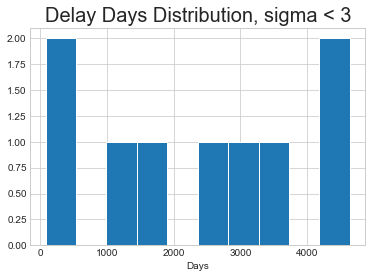

In [ ]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 3', fontsize=20)